In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from highlight_text import fig_text, ax_text
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import scipy.stats as stats

from mplsoccer import Pitch

from PIL import Image
import urllib
import os

In [2]:
plt.style.use("../../assets/stylesheets/soc_base.mplstyle")

In [3]:
df = pd.read_csv('../../data/soc/epl_long_balls.csv',index_col=0)

In [4]:
df = (df.groupby(['player_id', 'player_first_name', 'player_last_name'])[
      ['minutes', 'long_balls_att', 'long_balls_succ']].sum()).reset_index()


In [5]:
df_plot = df[(df['minutes'] >= df['minutes'].median()) & (
    df['long_balls_att'] >= df['long_balls_att'].median())]


In [6]:
df_plot = df_plot.assign(per_90=lambda x: (x.long_balls_att/x.minutes)*90)
df_plot = df_plot.assign(
    succ_rate=lambda x: x.long_balls_succ/x.long_balls_att).sort_values(by='per_90')


In [7]:
df_plot['zscore'] = stats.zscore(
    df_plot['per_90'])*.4 + stats.zscore(df_plot['succ_rate']*.6)
df_plot['annotated'] = [True if x >
                        df_plot['zscore'].quantile(.8) else False for x in df_plot['zscore']]


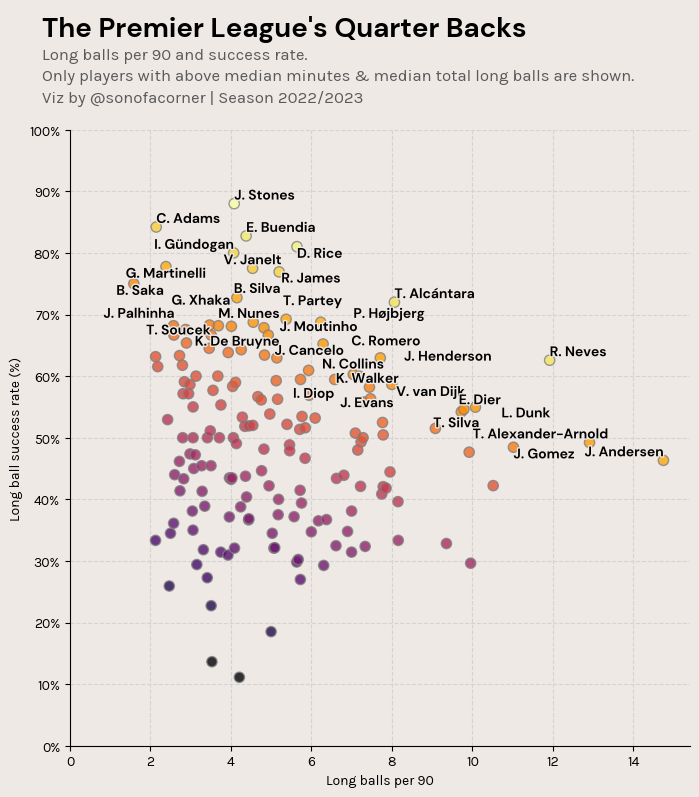

In [18]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = plt.subplot()
ax.grid(visible=True, ls='--', color='lightgrey')

ax.scatter(
    df_plot['per_90'], df_plot['succ_rate'],
    c=df_plot['zscore'], cmap='inferno',
    zorder=3, ec='grey', s=55, alpha=.8
)

texts = []
annotated_df = df_plot[df_plot['annotated']].reset_index(drop=True)
for index in range(annotated_df.shape[0]):
    texts += [
        ax.text(
            x=annotated_df['per_90'].iloc[index], y=annotated_df['succ_rate'].iloc[index],
            s=f"{annotated_df['player_first_name'].iloc[index][0]}. {annotated_df['player_last_name'].iloc[index]}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), path_effects.Normal()], color='black', family='DM Sans', weight='bold'
        )
    ]

adjust_text(texts, only_move={'points': 'y', 'text': 'xy', 'objects': 'xy'})

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax.set_xlim(0)
ax.set_ylim(0, 1)

ax.set_ylabel('Long ball success rate (%)')
ax.set_xlabel('Long balls per 90')

fig_text(
    x=0.09, y=.99,
    s="The Premier League's Quarter Backs",
    va="bottom", ha="left",
    fontsize=20, color="black", font="DM Sans", weight="bold"
)

fig_text(
    x=0.09, y=0.91,
    s="Long balls per 90 and success rate.\nOnly players with above median minutes & median total long balls are shown.\nViz by @sonofacorner | Season 2022/2023",
    va="bottom", ha="left",
    fontsize=12, color="#5A5A5A", font="Karla"
)
